In [1]:
import numpy as np
import pandas as pd
import xarray as xr

from pathlib import Path

import altair as alt
from altair.expr import datum

In [2]:
%load_ext watermark

In [3]:
%watermark --iversions

altair    3.0.1
numpy     1.16.3
pandas    0.24.2
xarray    0.12.0



In [4]:
from utils.load import load_dilution_data
from utils.calculate_metrics import (process_data, relative_errors, summary_errors)

## Set paths 

In [13]:
data_path = Path('../data')
path_to_results = data_path / "simulation_results"
khodayari_path = path_to_results / "Khodayari"
millard_path = path_to_results / "Millard"
kurata_path = path_to_results / "Kurata"
chassagnole_path = path_to_results / "Chassagnole"

# 1. Load the simulation data

In [5]:
dil_df, debug_info = load_dilution_data()

/Users/denshe/Work/KineticalModeling/EcoliKineticBenchmark/notebooks/utils/load.py:181: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([khodayari_dil, kurata_dil, millard_dil])


In [6]:
dil_df.head()

,BiGG_ID,ID,author,flux,normalized_flux,sample_id
0,ACALD,ACALD,Khodayari,-0.054344,-0.049474,0.2
1,composed of ACALDtex and ACALDtpp,ACALDtpp_ex,Khodayari,-0.004107,-0.003739,0.2
2,ACKr,ACKr,Khodayari,0.088129,0.080232,0.2
3,ACONTa,ACONTa,Khodayari,96.831733,88.154691,0.2
4,ACONTb,ACONTb,Khodayari,96.797201,88.123254,0.2


### Preprocess data

In [8]:
xdf = process_data(dil_df, author="Yao")

Consumption rate for D 0.2 is 3.07
Consumption rate for D 0.2 is 3.07
Consumption rate for D 0.4 is 4.75
Consumption rate for D 0.6 is 6.67
Consumption rate for D 0.7 is 8.05


# 2. Calculate error metrics

In [9]:
x_rel_error = relative_errors(xdf, author="Yao")

In [10]:
x_norm_error = summary_errors(xdf, author="Yao")

# 3. Visualize

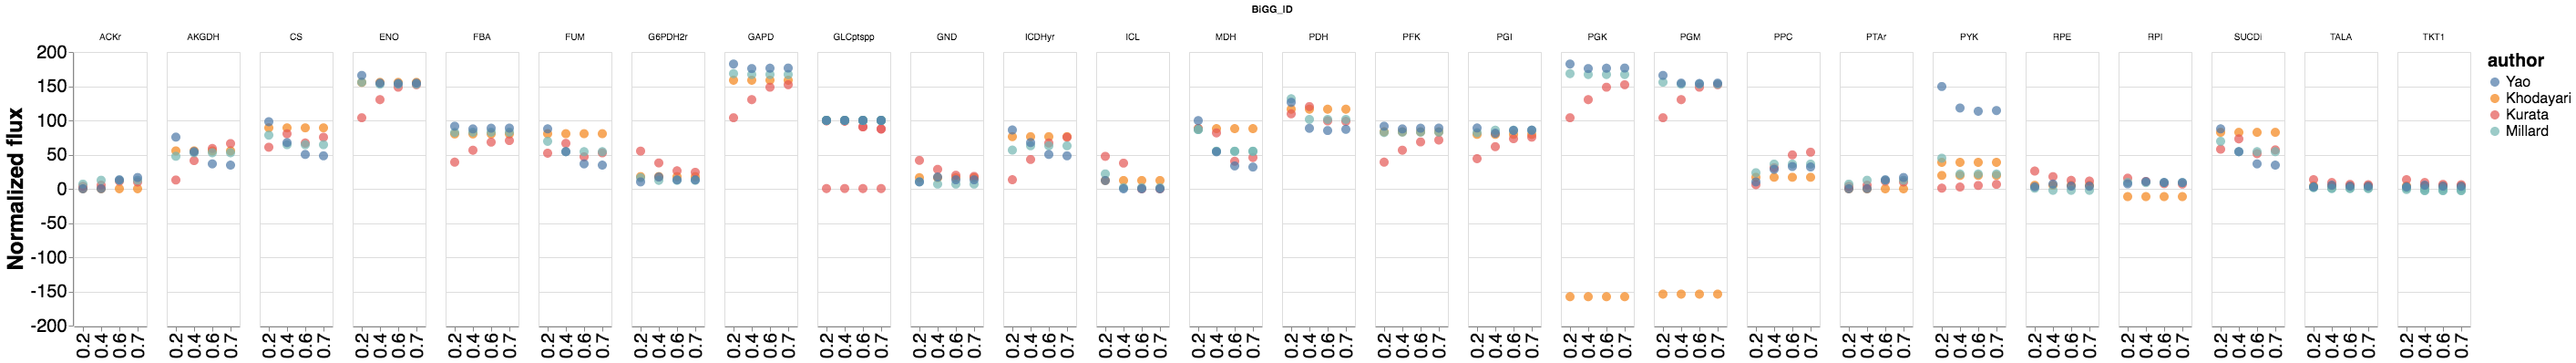

In [32]:
# put errors for each dataset as datapoints
chart = (
    alt.Chart(
        all_results.query('BiGG_ID in @selected_reactions'),
        # title = "Normalized error, ZWF sensitivity"
    )
    .mark_circle(size=100)
    .encode(
        y=alt.Y("normalized_flux", title="Normalized flux"),
        color=alt.Color("author", sort=["Yao", "Khodayari", "Kurata", "Millard"]),
        tooltip = ["author", "sample_id", "normalized_flux"],
        x=alt.X("sample_id:N", title=None),
    )
    .facet(column="BiGG_ID:N")
    .configure_axis(labelFontSize=20, titleFontSize=24)
    .configure_legend(labelFontSize=16, titleFontSize=20)
)

chart
# (errors + mean_error).properties(width=600, height = 500).configure_axis(labelFontSize = 20, titleFontSize = 24).configure_legend(labelFontSize = 16, titleFontSize = 20)
# errors

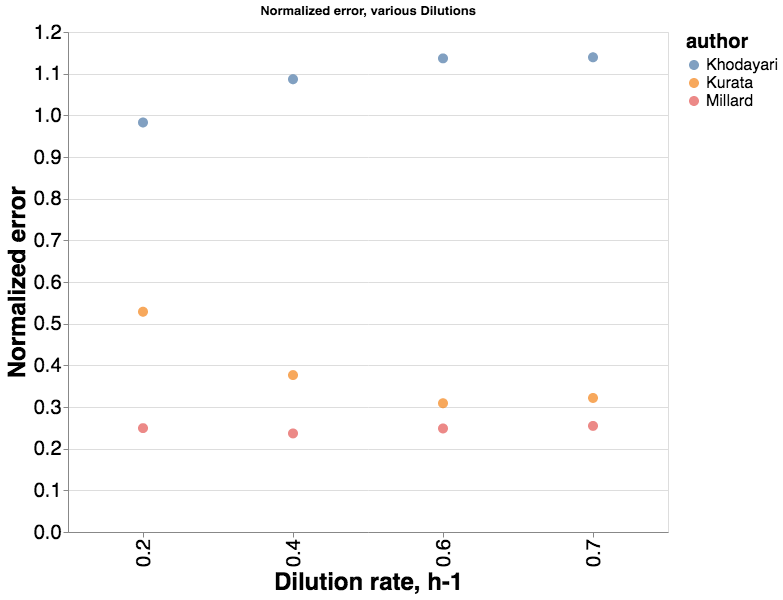

In [33]:
# put errors for each dataset as datapoints
errors = alt.Chart(
    normalized_errors.query("author != 'Yao'"),
    title = "Normalized error, various Dilutions"
).mark_circle(size = 100).encode(
    y=alt.Y("normalized_error", title = "Normalized error"),   
    color=alt.Color("author", sort=["Khodayari", "Kurata", "Millard"]),
    tooltip = ["author", "sample_id", "normalized_error"],
    x=alt.X("sample_id", sort=["0.2", "0.4", "0.6", "0.7"], title="Dilution rate, h-1"),
)

errors.properties(width=600, height = 500).configure_axis(labelFontSize = 20, titleFontSize = 24).configure_legend(labelFontSize = 16, titleFontSize = 20)
# errors

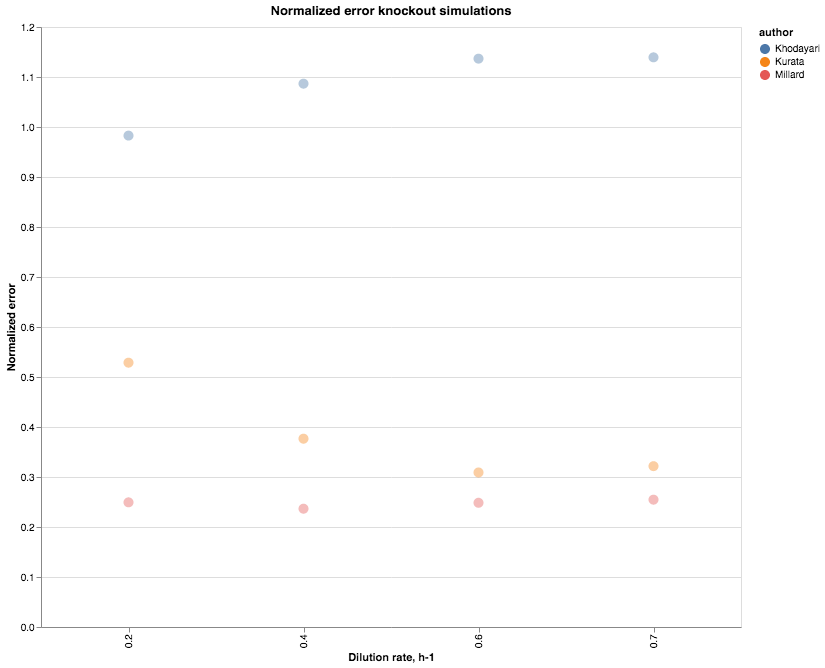

In [12]:
selector = alt.selection_single(empty="all", fields=["sample_id"])
color = alt.condition(
    selector,
    alt.Color(
        "author:N",
        sort=[
            "Khodayari",
            "Kurata",
            "Millard",
            "iML1515",
            "Ec_core",
            "ECC2",
            "Exp_ECC2",
        ],
    ),
    alt.ColorValue("lightgray"),
)

opacity = alt.condition(selector, alt.OpacityValue(0.4), alt.OpacityValue(1.0))

size = alt.condition(selector, alt.SizeValue(100), alt.SizeValue(40))


base = (
    alt.Chart(
        x_norm_error.to_dataframe()
        .reset_index()
        .query("author != 'Yao'"),
        title="Normalized error knockout simulations",
    )
    .mark_circle()
    .encode(
        y=alt.Y("normalized_error", title="Normalized error"),
        tooltip=["author", "sample_id", "normalized_error"],
        x=alt.X("sample_id", sort=["0.2", "0.4", "0.6", "0.7"], title="Dilution rate, h-1"),
        size=size,
        opacity = opacity,
    )
)

errors = (
    base
    .encode(color=color)
    .add_selection(selector)
    .transform_filter("datum.normalized_error !== null")
)

na_vals = base.encode(color=alt.value("lightgrey")).transform_filter("datum.normalized_error === null")


(errors).properties(width=700, height=600).configure_axis(
    labelFontSize=24, titleFontSize=24
).configure_legend(labelFontSize=16, titleFontSize=20).configure(invalidValues=None)
